# All plots for paper

In [1]:
include("../../../config.jl");
include(joinpath(LIB_PATH, "notebook-helpers.jl"));
include(joinpath(LIB_PATH, "bbcpf-blocking.jl"));
include(joinpath(LIB_PATH, "makie-visualisations.jl"));
include(joinpath(LIB_PATH, "math-functions.jl"));
R"""
source(file.path($PROJECT_ROOT, "src", "R", "r-plot-helpers.R"))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(latex2exp))
suppressPackageStartupMessages(library(patchwork))
""";
using Statistics: mean

In [2]:
# Plotting theme defaults.
R"""
THEME_SIZES <- theme(axis.title = element_text(size = 6),
                     axis.text = element_text(size = 4),
                     strip.text = element_text(size = 6),
                     legend.text = element_text(size = 5),
                     legend.title = element_text(size = 6))
""";

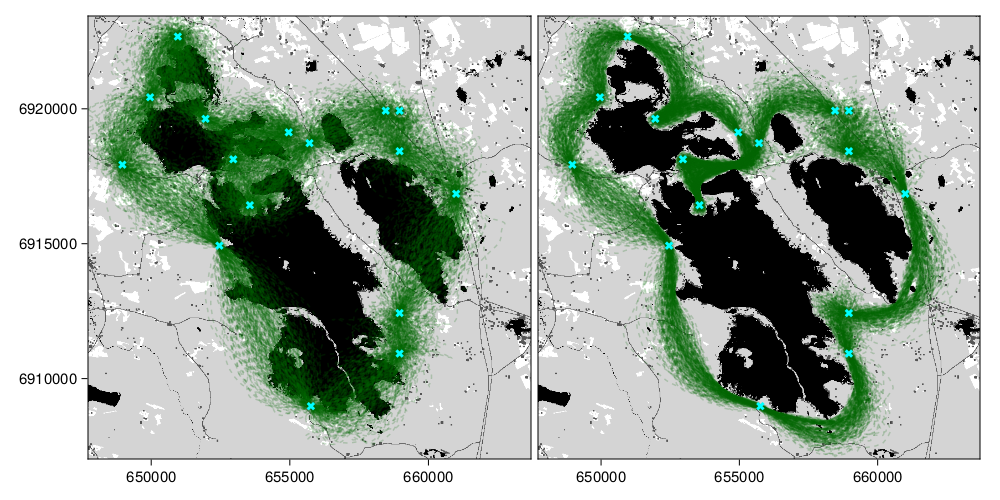

In [3]:
using CairoMakie
let 
    folder = joinpath(SIMEXP_PATH, "terrain-sim");
    infilepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize1.0-dt0.0078125-nsim10000.jld2");
    plot_trajectory_comparison(infilepath)
end

In [4]:
bbcpf = let
    folder = joinpath(SIMEXP_PATH, "terrain-sim")
    filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize1.0-dt0.0078125-nsim10000.jld2")
    d = jldopen(filepath, "r") do file
        out = Dict{Symbol, Any}()
        for k in keys(file)
            out[Symbol(k)] = file[k]
        end
        out
    end
end
cpfbs = let
    folder = joinpath(SIMEXP_PATH, "terrain-sim")
    filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize0.0078125-dt0.0078125-nsim10000.jld2")
    d = jldopen(filepath, "r") do file
        out = Dict{Symbol, Any}()
        for k in keys(file)
            out[Symbol(k)] = file[k]
        end
        out
    end
end
filepath = joinpath(OUTPUT_PATH, "cpfbbs-vs-cpfbs-terrain-movement-systematic.mp4");
using GLMakie
compare_terrain_sim_anim((; bbcpf...), (; cpfbs...), filepath = filepath)

"/home/santeri/work/cpf-bbs/output/cpfbbs-vs-cpfbs-terrain-movement-systematic.mp4"

In [5]:
plot_data = let
    filepaths = readdir(joinpath(SIMEXP_PATH, "blocksize-vs-param-ctcrwp-b"), join = true)
    reduce_to_dataframe(filepaths) do file
        d = DataFrame(
            t = file["state-var-times"], 
            iactBM = file["iactBM-by-state"][1],
            nsim = file["args"]["nsim"],
            burnin = file["args"]["burnin"],
            meandiff = abs.(file["ksmoother-mean-by-state"][1] .- file["mean-est-by-state"][1]),
            blocksize = file["args"]["blocksize"],
            grand_local_change_prop = mean(file["local-ref-changes"] ./ file["args"]["nsim"]),
            npar = file["args"]["npar"],
            sigma = file["theta"].sigma,
            resampling = file["args"]["resampling"],
            dt = file["args"]["dt"]
        )
        filter(r -> r[:t] == 0.0, d)
    end
end;

In [6]:
println("burnin: $(unique(plot_data[!, :burnin]))")
println("nsim: $(unique(plot_data[!, :nsim]))")
println("Unique sigma values: $(unique(plot_data[!, :sigma]))")
println("Unique npar: $(sort(unique(plot_data[!, :npar])))")
println("Unique dt: $(unique(plot_data[!, :dt]))")
println("Resamplings: $(unique(plot_data[!, :resampling]))")

burnin: [1000]
nsim: [20000]
Unique sigma values: [0.125, 0.5, 2.0]
Unique npar: [2, 4, 8, 16, 32]
Unique dt: [0.0078125]
Resamplings: ["killing", "systematic", "multinomial"]


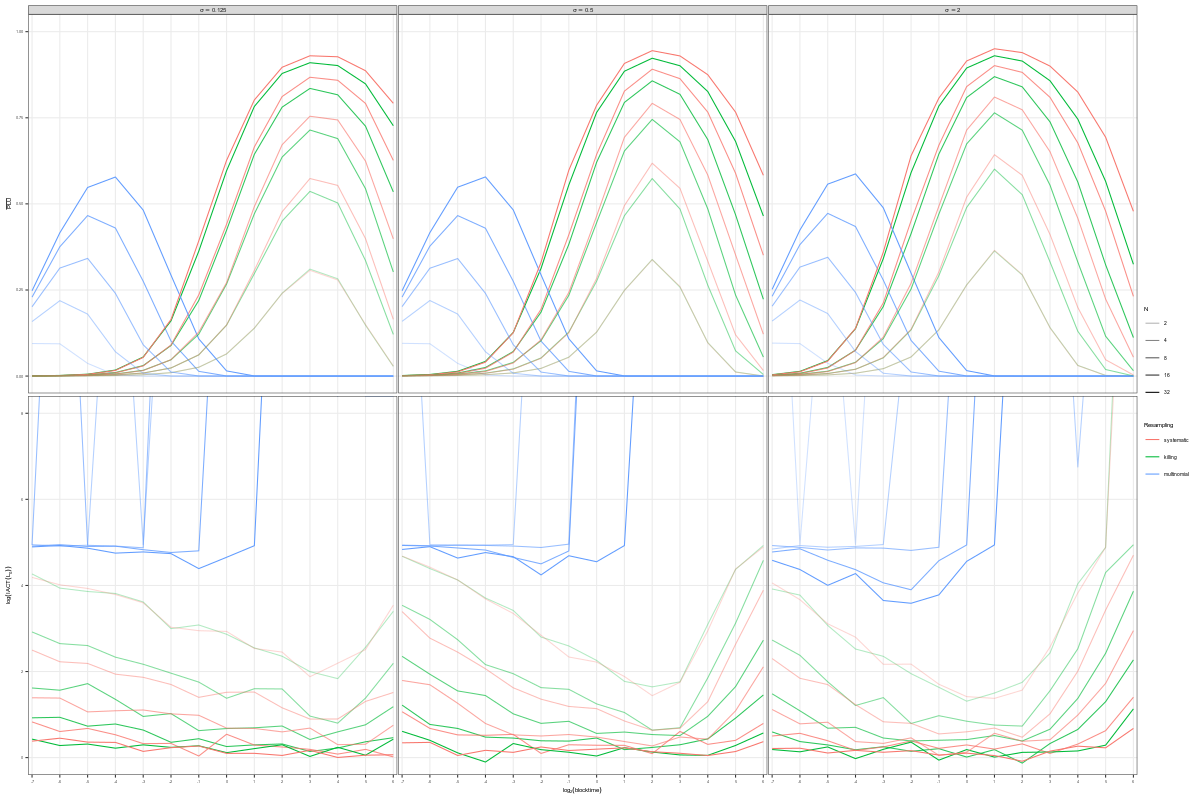

RObject{VecSxp}


In [7]:
set_plot_size!(1200, 800)
R"""
library(ggplot2)
library(latex2exp)
library(patchwork)

d <- $plot_data
n_npar_uniq <- length(unique(d[["npar"]]))
d[["blocksize_fact"]] <- numeric_to_factor(log2(d[["blocksize"]]))
d[["sigma_fact"]] <- numeric_to_factor(d[["sigma"]], textprefix = "sigma == ")
d[["npar_fact"]] <- numeric_to_factor(d[["npar"]], decreasing = FALSE)
d[["npar_res_prod"]] <- paste0(d[["npar"]], d[["resampling"]])
d[["resampling_fact"]] <- factor(d[["resampling"]], levels = c("systematic", "killing", "multinomial"))
alpha_range <- seq(0.3, 1.0, length.out = n_npar_uniq)
plt_sigma_lcprop <- ggplot(d, aes(x = blocksize_fact, y = grand_local_change_prop)) +
    geom_line(aes(color = resampling_fact, alpha = npar_fact, group = npar_res_prod)) +
    facet_wrap(~ sigma_fact, labeller = label_parsed) +
    scale_x_discrete(expand = rep(0.01, 2)) +
    scale_y_continuous(limits = c(0, 1)) +
    scale_color_discrete(name = "Resampling") +
    scale_alpha_manual(name = "N", values = alpha_range) +
    labs(x = TeX("$\\log_2(blocktime)$"), y = TeX("$\\bar{PLU}$")) + 
    theme_bw()

plt_sigma_iact0 <- ggplot(d, aes(x = blocksize_fact, y = log(iactBM))) +
    geom_line(aes(alpha = npar_fact, color = resampling_fact, group = npar_res_prod)) +
    facet_wrap(~ sigma_fact, labeller = label_parsed) +
    scale_x_discrete(expand = rep(0.01, 2)) +
    scale_color_discrete(name = "Resampling") +
    scale_alpha_manual(name = "N", values = alpha_range) +
    scale_linetype_discrete(name = "Resampling") +
    coord_cartesian(ylim = c(0, 8)) +
    labs(x = TeX("$\\log_2(blocktime)$"), y = TeX("$\\log(IACT(L_{0.0}))$")) + 
    theme_bw()

theme_common <- THEME_SIZES +
                theme(panel.grid.minor.y = element_blank(),
                      legend.box.margin = margin(0, 0, 0, -7))


plt_out <- (
    plt_sigma_lcprop + 
    theme_common +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
          panel.spacing.x = unit(1, "pt"),
          plot.margin = unit(c(0, 0, 0, 0), "pt"))
) / 
(
    plt_sigma_iact0 +
    theme_common +
    theme(plot.margin = unit(c(0, 0, 0, 0), "pt"),
          panel.spacing.x = unit(1, "pt"),
          strip.text = element_blank())

) + plot_layout(guides = 'collect') & theme(legend.box.margin = margin(0, 0, 0, -10))
# & is from patchwork meaning to apply to all subplots.
plt_out
"""

In [8]:
plot_data = let
    filepaths = readdir(joinpath(SIMEXP_PATH, "blocksize-vs-potential-ctcrwp-b"), join = true)
    reduce_to_dataframe(filepaths) do file
        d = DataFrame(
            t = file["state-var-times"], 
            nsim = file["args"]["nsim"],
            burnin = file["args"]["burnin"],
            iactBM = file["iactBM-by-state"][1],
            meandiff = abs.(file["ksmoother-mean-by-state"][1] .- file["mean-est-by-state"][1]),
            blocksize = file["args"]["blocksize"],
            grand_local_change_prop = mean(file["local-ref-changes"] ./ file["args"]["nsim"]),
            npar = file["args"]["npar"],
            tau = file["theta"].tau,
            resampling = file["args"]["resampling"],
            dt = file["args"]["dt"]
        )
        filter(r -> r[:t] == 0.0, d)
    end
end;

In [9]:
println("burnin: $(unique(plot_data[!, :burnin]))")
println("nsim: $(unique(plot_data[!, :nsim]))")
println("Unique tau values: $(unique(plot_data[!, :tau]))")
println("Unique npar: $(sort(unique(plot_data[!, :npar])))")
println("Unique dt: $(unique(plot_data[!, :dt]))")
println("Resamplings: $(unique(plot_data[!, :resampling]))")

burnin: [1000]
nsim: [20000]
Unique tau values: [0.125, 0.5, 2.0]
Unique npar: [2, 4, 8, 16, 32]
Unique dt: [0.0078125]
Resamplings: ["killing", "systematic", "multinomial"]


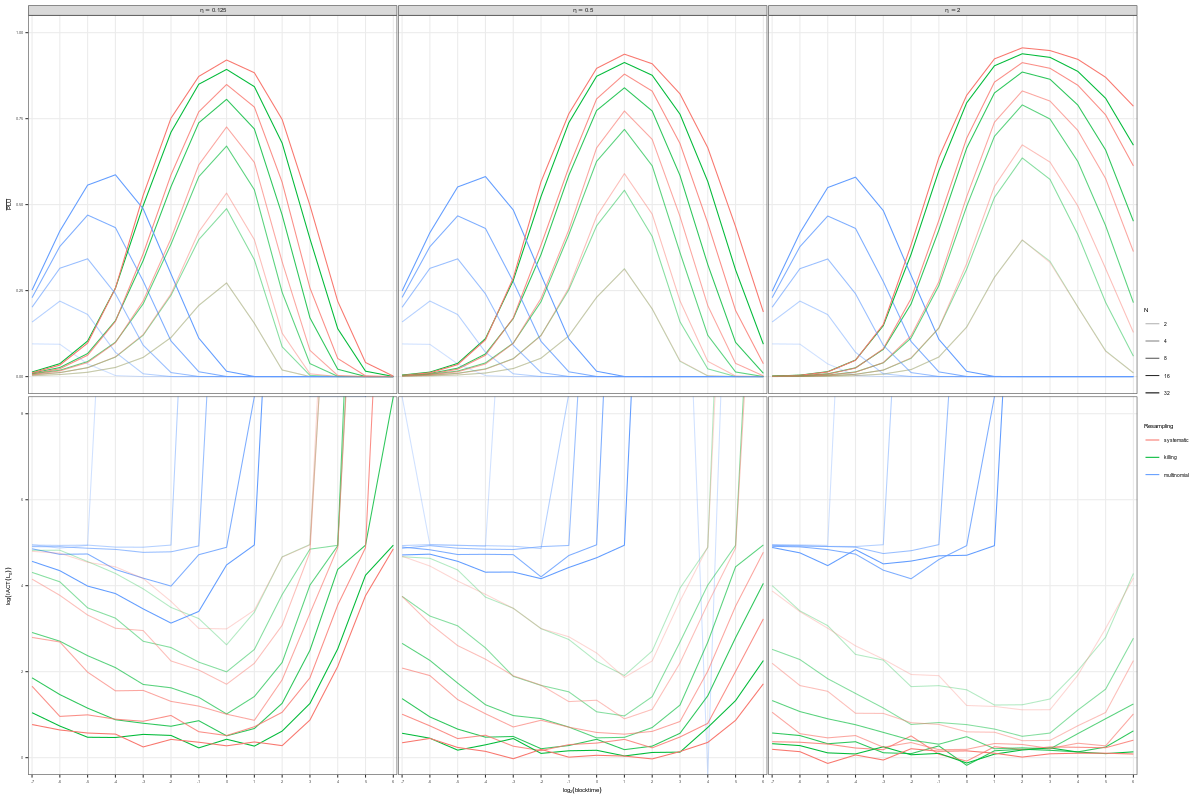

RObject{VecSxp}


In [10]:
set_plot_size!(1200, 800)
R"""
library(ggplot2)
library(latex2exp)
library(patchwork)

d <- $plot_data
n_npar_uniq <- length(unique(d[["npar"]]))
d[["blocksize_fact"]] <- numeric_to_factor(log2(d[["blocksize"]]))
d[["eta_fact"]] <- numeric_to_factor(d[["tau"]], textprefix = "eta == ")
d[["npar_fact"]] <- numeric_to_factor(d[["npar"]], decreasing = FALSE)
d[["npar_res_prod"]] <- paste0(d[["npar"]], d[["resampling"]])
d[["resampling_fact"]] <- factor(d[["resampling"]], levels = c("systematic", "killing", "multinomial"))
alpha_range <- seq(0.3, 1.0, length.out = n_npar_uniq)
plt_tau_lcprop <- ggplot(d, aes(x = blocksize_fact, y = grand_local_change_prop)) +
    geom_line(aes(color = resampling_fact, alpha = npar_fact, group = npar_res_prod)) +
    facet_wrap(~ eta_fact, labeller = label_parsed) +
    scale_x_discrete(expand = rep(0.01, 2)) +
    scale_y_continuous(limits = c(0, 1)) +
    scale_color_discrete(name = "Resampling") +
    scale_alpha_manual(name = "N", values = alpha_range) +
    labs(x = TeX("$\\log_2(blocktime)$"), y = TeX("$\\bar{PLU}$")) + 
    theme_bw()

plt_tau_iact0 <- ggplot(d, aes(x = blocksize_fact, y = log(iactBM))) +
    geom_line(aes(alpha = npar_fact, color = resampling_fact, group = npar_res_prod)) +
    facet_wrap(~ eta_fact, labeller = label_parsed) +
    scale_x_discrete(expand = rep(0.01, 2)) +
    scale_color_discrete(name = "Resampling") +
    scale_alpha_manual(name = "N", values = alpha_range) +
    scale_linetype_discrete(name = "Resampling") +
    coord_cartesian(ylim = c(0, 8)) +
    labs(x = TeX("$\\log_2(blocktime)$"), y = TeX("$\\log(IACT(L_{0.0}))$")) + 
    theme_bw()

theme_common <- THEME_SIZES +
                theme(panel.grid.minor.y = element_blank())


plt_out <- (
    plt_tau_lcprop + 
    theme_common +
    theme(axis.title.x = element_blank(),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank(),
          strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
          panel.spacing = unit(1, "pt"),
          plot.margin = unit(c(0, 0, 0, 0), "pt"))
) / 
(
    plt_tau_iact0 +
    theme_common +
    theme(plot.margin = unit(c(0, 0, 0, 0), "pt"),
          panel.spacing = unit(1, "pt"),
          strip.text = element_blank())

) + plot_layout(guides = 'collect') & theme(legend.box.margin = margin(0, 0, 0, -10))
plt_out
"""

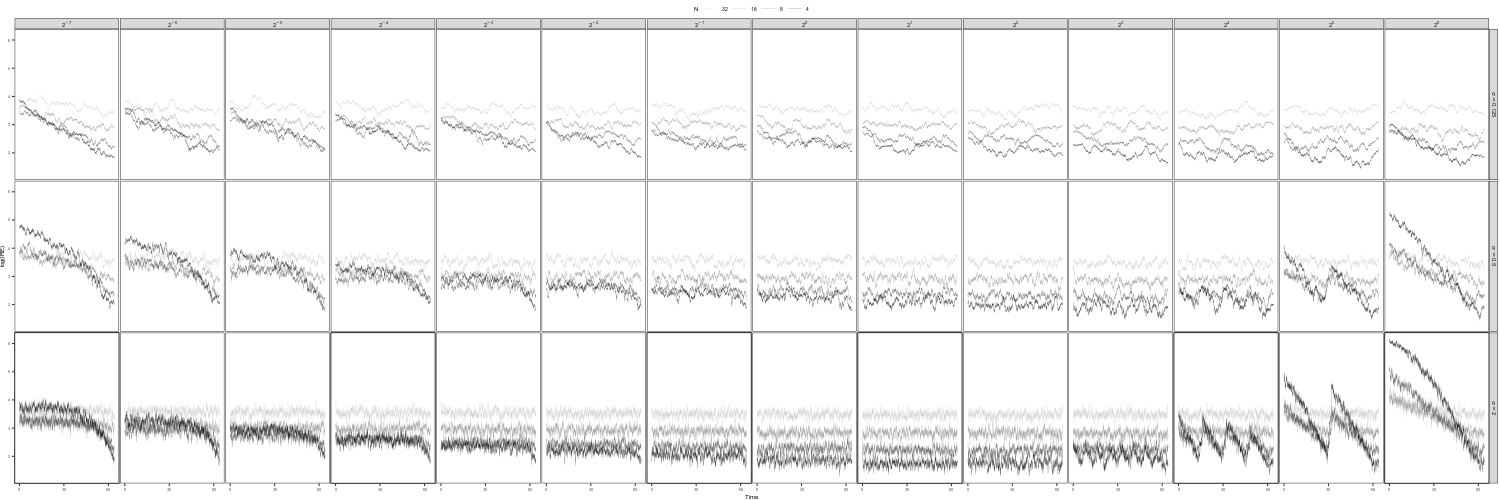

RObject{VecSxp}


In [11]:
let
    folder = joinpath(SIMEXP_PATH, "blocksize-vs-param-ctcrwp-b");
    filepaths = readdir(folder, join = true);
    inp = reduce_to_dataframe(filepaths) do file 
        DataFrame(
            t = file["state-var-times"], 
            iactBM = file["iactBM-by-state"][1],
            esjd = file["esjd"],
            meandiff = abs.(file["ksmoother-mean-by-state"][1] .- file["mean-est-by-state"][1]),
            blocksize = file["args"]["blocksize"],
            npar = file["args"]["npar"],
            sigma = file["theta"].sigma,
            resampling = file["args"]["resampling"]
        )
    end |> x -> filter(r -> r[:resampling] == "systematic", x)
    
    set_plot_size!(1500, 500)
    R"""
    library(ggplot2); suppressWarnings(library(dplyr))
    d <- filter($inp, npar >= 4)
    n_npar_uniq <- length(unique(d[["npar"]]))
    d[["npar_fact"]] <- factor(d[["npar"]], levels = sort(unique(d[["npar"]]), decreasing = TRUE))
    d[["sigma_fact"]] <- numeric_to_factor(d[["sigma"]], textprefix = "sigma==")
    d[["blocksize_fact"]] <- numeric_to_factor(log2(d[["blocksize"]]), textprefix = "2^")
    plt_iact_all_times_sigma <- ggplot(d, aes(x = t, y = log(iactBM * npar))) +
        geom_line(aes(color = npar_fact), size = 0.1, alpha = 0.75) +
        facet_grid(sigma_fact ~ blocksize_fact, labeller = label_parsed) +
        scale_x_continuous(breaks = c(0, 30, 60)) +
        scale_color_manual(values = GRAY_TO_BLACK_COLOR_FUN(n_npar_uniq), name = "N") + 
        labs(y = "log(IRE)", x = "Time") +
        theme_bw() +
        THEME_SIZES +
        theme(legend.position = "top",
              axis.text.x = element_text(size = 4),
              axis.title = element_text(size = 6),
              legend.title = element_text(size = 6),
              panel.grid = element_blank(),
              legend.margin = margin(0, 0, 0, 0),
              legend.box.margin = margin(0, 0, -10, 0),
              panel.spacing = unit(1, "pt"),
              strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
              strip.text.y = element_text(margin = margin(0, 2, 0, 2, "pt")),
              plot.margin = margin(0, 2, 0, 0))
        plt_iact_all_times_sigma
    """
end

In [12]:
metric_data = let
    folder = joinpath(SIMEXP_PATH, "block-metrics-sys-ctcrwp", "20220317", "block-metrics-sys-ctcrwp")
    filepaths = readdir(folder, join = true);
    reduce_to_dataframe(filepaths) do file
        out = DataFrame();
        state_var_times = file["state-var-times"];
        T = file["args"]["T"];
        dt = file["args"]["dt"];
        blocksizes = file["args"]["blocksizes"];
        block_essprop_m = file["block-essprop-M"];
        lbsp_m = file["lbsp-M"];
        pdn = file["pdn"];
        sigma = file["theta"].sigma;
        npar = file["args"]["npar"];
        p_mult = (npar / ((npar - 1)^ 2));
        #n0_pdn = n0_pdns[sigma];

        for (i, blocksize) in enumerate(blocksizes)
            nblocks = convert(Int, T / blocksize);
            blocks = get_even_bbcpf_blocking(dt, blocksize, T);
            block_l_time = state_var_times[map(first, blocks)];
            plu_est = map(enumerate(blocks)) do jb
                j, b = jb;
                l, u = b;
                plu_m_reps = lbsp_m[i][j, :];
                plu_g_reps = exp.(mapslices(x -> sum(log.(1.0 .- p_mult .* x)), 
                                  view(pdn, l:(u - 1), :), dims = 1)[1, :]);
                mean(plu_m_reps .* plu_g_reps);
            end
            append!(out, DataFrame(
                npar = npar,
                sigma = sigma,
                block_l_time = block_l_time,
                blocksize = blocksize,
                plu_est = plu_est
            ));
        end
        out
    end
end
    
plu_data = let
   folder = joinpath(SIMEXP_PATH, "ctcrwp-plu-est", "20220321", "bbcpf-blocksize-ctcrwp-b")
   filepaths = readdir(folder, join = true);
   reduce_to_dataframe(filepaths) do file
       DataFrame(
            npar = file["args"]["npar"],
            sigma = file["theta"].sigma,
            blocksize = file["args"]["blocksize"],
            block_l_time = file["state-var-times"][map(first, file["blocks"])],
            plu = file["local-ref-changes"] ./ file["args"]["nsim"]
       )
   end
end

cs, cbs = let
    combined = leftjoin(metric_data, plu_data, on = [:npar, :sigma, :blocksize, :block_l_time]);
    combined_s = stack(combined, [:plu_est, :plu]);
    gdb = groupby(combined, [:npar, :sigma, :blocksize])
    combined_over_blocks = combine(gdb, 
                                   :plu_est => mean => :grand_plu_est,
                                   :plu => mean => :grand_plu);
    combined_over_blocks_s = stack(combined_over_blocks, [:grand_plu_est, :grand_plu]);
    combined_s, combined_over_blocks_s;
end;

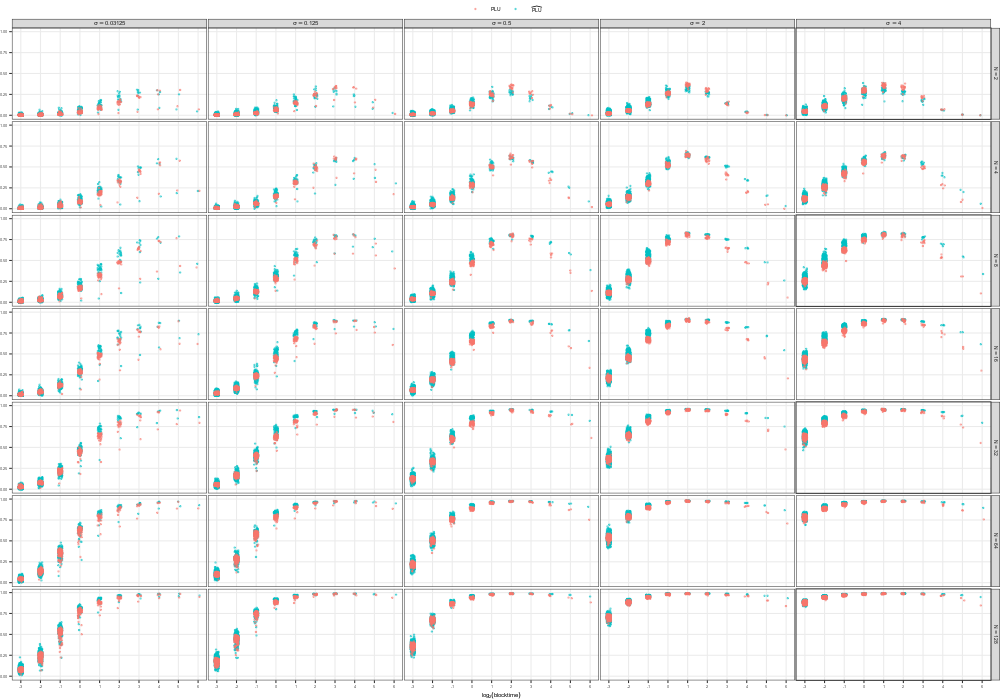

RObject{VecSxp}


In [13]:
set_plot_size!(1000, 700)
R"""
d <- $cs
d <- filter(d, variable %in% c("plu_est", "plu"), npar <= 128)
d[["npar_fact"]] <- numeric_to_factor(d[["npar"]], textprefix = "N==")
d[["sigma_fact"]] <- numeric_to_factor(d[["sigma"]], textprefix = "sigma==")
#variable_lookup <- c(plu = "PLU", mean_eff = "EFF", mean_eff_adj = "EFF adjusted")
variable_lookup <- c(plu = "PLU", plu_est = "PLU EST") 
d[["variable_fact"]] <- factor(variable_lookup[d[["variable"]]], levels = unname(variable_lookup))

plt_plu_vs_plu_est_no_mean <- ggplot(d, aes(x = log2(blocksize), y = value)) +
    geom_jitter(aes(color = variable_fact), size = 0.5, width = 0.1, alpha = 0.5) +
    facet_grid(npar_fact ~ sigma_fact, labeller = label_parsed) +
    scale_x_continuous(breaks = seq(-6, 7, 1)) +
    scale_color_discrete(name = "Variable", labels = c(~PLU, ~widehat(PLU))) +
    labs(x = TeX("$\\log_2(blocktime)$")) +
    coord_cartesian(xlim = c(-3, 6)) +
    theme_bw() + 
    THEME_SIZES +
    theme(axis.title.y = element_blank(),
          panel.spacing.y = unit(2, "pt"),
          panel.spacing.x = unit(1, "pt"),
          strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
          strip.text.y = element_text(size = 5, margin = margin(0, 2, 0, 2, "pt")),
          legend.position = "top",
          legend.title = element_blank(),
          legend.box.margin = margin(0, 0, -10, 0),
          plot.margin = unit(c(0, 0, 0, 0), "pt"),
          panel.grid.minor = element_blank(),
          #legend.key.size = unit(5, 'pt'), 
          legend.key.height = unit(5, 'pt'))

plt_plu_vs_plu_est_no_mean
"""

In [14]:
lgcpr_iacts = let
    filepaths = readdir(joinpath(SIMEXP_PATH, "lgcpr-opt-vs-hom", "20220419", "bbcpf-lgcpr", "summaries"), join = true)
    reduce_to_dataframe(filepaths) do file
        seed = file["args"]["seed"];
        dts = jldopen(joinpath(INPUT_PATH, "lgcpr-data", string(seed) * ".jld2"), "r") do file
            file["data"].dt
        end
        state_var_times = vcat([0.0], cumsum(dts)[1:(end - 1)])
        DataFrame(
            t = state_var_times,
            iactBM = file["iactBM"],
            blocksize = isnothing(file["args"]["blocksize"]) ? -1.0 : 
                                    file["args"]["blocksize"]
        )
    end
end;

In [15]:
using Distributions
lgcpr_summ = let
    filepath = readdir(joinpath(SIMEXP_PATH, "lgcpr-result"), join = true);
    jldopen(only(filepath), "r") do file
        qs = mapslices(x -> quantile(x, [0.005, 0.025, 0.05, 0.25, 0.50, 0.75, 0.95, 0.975, 0.995]), file["s"], dims = 2);
        out = DataFrame(qs, [:q005, :q025, :q05, :q25, :q50, :q75, :q95, :q975, :q995]);
        out[!, :t] = file["state-var-times"];
        out;
    end
end;

In [16]:
tau_df, true_state_df = let
    tau, true_state, dt, T = let
        filepath = joinpath(INPUT_PATH, "lgcpr-data", "12345.jld2");
        jldopen(filepath, "r") do file
            file["tau"], file["true-state"], file["args"]["base-dt"], file["args"]["T"]
        end
    end;
    true_state_df = DataFrame(t = collect(0.0:dt:(T - dt)),
                              x = true_state);
    tau_df = DataFrame(tau = tau);
    tau_df, true_state_df;
end;

In [17]:
block_changes_df = let
    filepath = joinpath(INPUT_PATH, "lgcpr-data", "blocking-12345-cpf-metrics.jld2")
    jldopen(filepath, "r") do file
        state_var_times = vcat([0.0], cumsum(file["dts"])[1:(end - 1)])
        block_l_times = state_var_times[map(first, file["blocks"])]
        DataFrame(block_l_time = block_l_times,
                  blocksize = file["blocksizes"]);
    end
end;

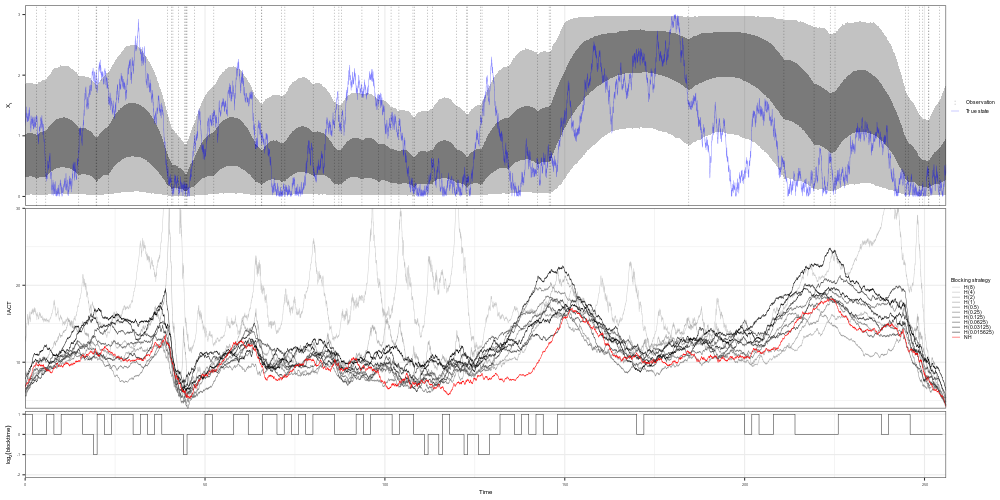

RObject{VecSxp}


In [18]:
set_plot_size!(1000, 500)
R"""
LINESIZE <- 0.2
THEME_LEG <- theme(legend.key.size = unit(5, 'pt'), 
                   legend.key.height = unit(5, 'pt'), 
                   legend.key.width = unit(10, 'pt'), 
                   legend.text = element_text(size = 6), 
                   legend.margin = margin(0, 0, 0, 0),
                   legend.box.margin = margin(0, 0, 0, -7))

##
d <- $lgcpr_summ
plt_lgcpr_res <- ggplot(d, aes(x = t, y = q50)) +
    geom_ribbon(aes(ymin = q025, ymax = q975), alpha = 0.3) +
    geom_ribbon(aes(ymin = q25, ymax = q75), alpha = 0.5) +
    geom_step(data = $true_state_df, aes(x = t, y = x, color = "True state"), size = LINESIZE, alpha = 0.5, inherit.aes = FALSE) +
    geom_vline(data = $tau_df, aes(xintercept = tau, linetype = "Observation"), alpha = 0.8, size = LINESIZE) +
    scale_x_continuous(expand = rep(0, 2)) +
    scale_color_manual(name = "", values = "blue") +
    scale_linetype_manual(name = "", values = "dotted") +
    labs(x = "Time", y = TeX("$X_t$")) +
    theme_bw() +
    THEME_LEG +
    THEME_SIZES + 
    theme(panel.grid.minor = element_blank(),
          panel.grid.major.y = element_blank(),
          axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.x = element_blank(), 
          plot.margin = margin(0, 0, 0, 0),
          legend.spacing.y = unit(2, "pt"),
          legend.title = element_blank())

##
d <- $lgcpr_iacts
d <- filter(d, blocksize <= 8)
blocksize_uniq <- sort(unique(d[["blocksize"]]))
blocksize_uniq <- blocksize_uniq[blocksize_uniq > 0]
hybrid_name <- "NH"
hybrid_color <- "#ff0000"

strategy_levels <- c(paste0("H(", blocksize_uniq[order(blocksize_uniq, decreasing = TRUE)], ")"), 
                     hybrid_name)
strategy_values <- ifelse(d[["blocksize"]] > 0, 
                          paste0("H(", d[["blocksize"]], ")"), 
                          hybrid_name)
d[["strategy"]] <- factor(strategy_values,
                          levels = strategy_levels) 
colorfun <- colorRampPalette(c("#C6C6C6", "black"))
blocksizecolors <- c(colorfun(length(blocksize_uniq)), hybrid_color) 

plt_lgcpr_iacts <- ggplot(d, aes(x = t, y = iactBM)) +
    geom_line(aes(color = factor(strategy)), size = LINESIZE) + 
    scale_x_continuous(expand = rep(0, 2)) +
    scale_y_continuous(expand = rep(0, 2)) +
    scale_color_manual(name = "Blocking strategy", values = blocksizecolors) + 
    coord_cartesian(ylim = c(4, 30)) +
    labs(y = "IACT", x = "Time") +
    theme_bw() + 
    THEME_LEG +
    THEME_SIZES + 
    theme(axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_text(size = 5),
          plot.margin = margin(0, 0, 0, 0))

##
d <- $block_changes_df
plt_block_changes <- ggplot(d, aes(x = block_l_time, y = log2(blocksize))) +
    geom_step(size = LINESIZE) +
    scale_y_continuous(breaks = seq(-7, 7, by = 1)) +
    scale_x_continuous(expand = rep(0, 2)) +
    coord_cartesian(ylim = c(-2, 1), xlim = c(0, 256)) +
    labs(x = "Time", y = TeX("$\\log_2(blocktime)$")) +
    THEME_SIZES + 
    theme_bw() + 
    theme(plot.margin = margin(-2, 0, 0, 0),
          panel.grid.minor.y = element_blank())

plt_lgcpr <- plt_lgcpr_res / plt_lgcpr_iacts / plt_block_changes + 
    plot_layout(heights = c(3, 3, 1)) + THEME_SIZES

plt_lgcpr
"""

In [19]:
plot_data, blocking_df = let 
    folder = joinpath(SIMEXP_PATH, "terrain-sim");
    bbcpf_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize1.0-dt0.0078125-nsim10000.jld2");
    cpfbs_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize0.0078125-dt0.0078125-nsim10000.jld2");
    bbcpf_blocked_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blockfile-dt0.0078125-nsim10000.jld2");
    vars = ["pmux"]
    
    bbcpf = jldopen(bbcpf_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "bbcpf"
        out
    end
    bbcpf_blocked = jldopen(bbcpf_blocked_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "bbcpf_blocked"
        out
    end
    cpfbs = jldopen(cpfbs_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "cpfbs"
        out
    end
    blocking_df = let
        filepath = joinpath(INPUT_PATH, "ctcrwt-data", 
               "blocking-ctcrwt-dt0.0078125-watercoef0.0-npar512-nreps25.jld2");
        jldopen(filepath, "r") do file
            DataFrame(block_l_time = file["state-var-times"][map(first, file["blocks"])],
                      blocksize = file["blocksizes"])
        end
    end
    plot_data = stack(vcat(bbcpf, cpfbs, bbcpf_blocked), Symbol.(vars), 
          variable_name = :variable, value_name = :iact);
    sort!(blocking_df, :block_l_time);
    append!(blocking_df, 
        DataFrame(block_l_time = blocking_df[end, :block_l_time] + blocking_df[end, :blocksize], 
            blocksize = blocking_df[end, :blocksize])
    )
    
    plot_data, blocking_df
end;

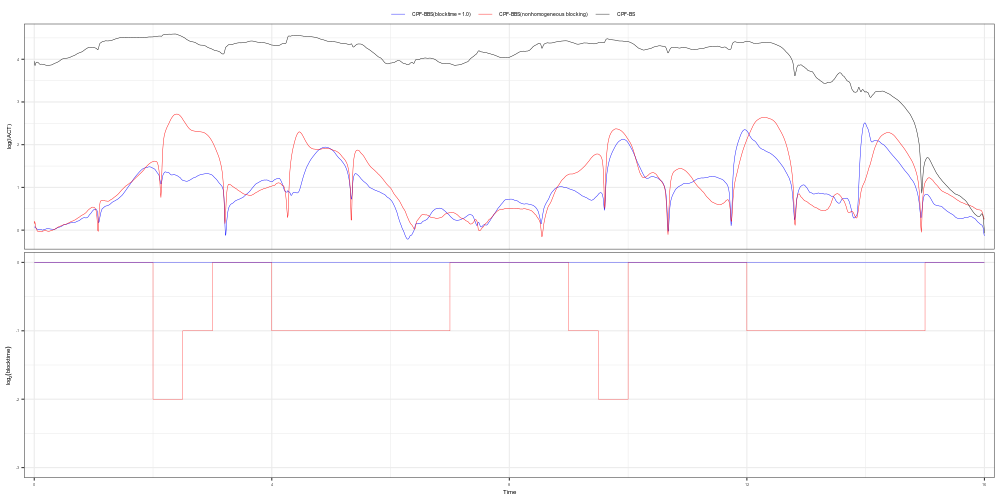

RObject{VecSxp}


In [20]:
R"""
library(latex2exp)
d <- $plot_data
alg_lookup <- c(bbcpf = "CPF-BBS(blocktime = 1.0)", bbcpf_blocked = "CPF-BBS(nonhomogeneous blocking)",
                cpfbs = "CPF-BS")
variable_lookup <- c(pmux = "L[t]^{(x)}", pmuy = "L[t]^{(y)}", pvx = "V[t]^{(x)}", pvy = "V[t]^{(y)}")
d[["variable_fact"]] <- factor(variable_lookup[d[["variable"]]], levels = unname(variable_lookup))
d[["alg_fact"]] <- factor(alg_lookup[d[["alg"]]], levels = unname(alg_lookup))

alg_colors <- c("blue", "red", "black")
LINESIZE <- 0.2

plt_bbcpf_vs_cpfbs_smalldt <- 
    ggplot(d, aes(x = t, y = log(iact) )) +
    geom_line(aes(color = alg_fact), size = LINESIZE) +
    #facet_wrap(~ variable_fact, labeller = label_parsed) +
    scale_color_discrete(name = "Algorithm", type = alg_colors) +
    
    scale_x_continuous(expand = rep(0.01, 2)) +
    labs(y = "log(IACT)", x = "Time") +
    theme_bw() +
    THEME_SIZES +
    theme(legend.position = "top",
          legend.title = element_blank(),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(0, 0, -10, 0),
          strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
          plot.margin = margin(0, 2, 0, 0),
          panel.spacing = unit(1, "pt")) + 
    theme(axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_blank(),#text(size = 5),
          plot.margin = margin(0, 0, 0, 0))

plt_blocking <- ggplot($blocking_df, aes(x = block_l_time, y = log2(blocksize))) +
    geom_step(size = LINESIZE, color = alg_colors[2], alpha = 0.7) +
    geom_step(data = data.frame(block_l_time = c(0.0, 16.0), blocksize = c(1.0, 1.0)), color = alg_colors[1],
              size = LINESIZE, alpha = 0.7) +
    scale_x_continuous(expand = rep(0.01, 2)) +
    coord_cartesian(xlim = c(0, 16), ylim = c(-3, 0)) +
    labs(x = "Time", y = TeX("$\\log_2(blocktime)$")) +
    theme_bw() +
    theme(plot.margin = margin(0, 0, 0, 0)) +
    THEME_SIZES

plt_out <- plt_bbcpf_vs_cpfbs_smalldt / plt_blocking
plt_out
"""

In [21]:
plot_data, blocking_df = let 
    folder = joinpath(SIMEXP_PATH, "terrain-sim");
    bbcpf_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize1.0-dt0.125-nsim10000.jld2");
    cpfbs_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blocksize0.125-dt0.125-nsim10000.jld2")
    bbcpf_blocked_filepath = joinpath(folder, "terrain-sim-systematic-npar16-blockfile-dt0.125-nsim10000.jld2");
    vars = ["pmux"] #, "pmuy", "pvx", "pvy"];
    
    bbcpf = jldopen(bbcpf_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "bbcpf"
        out
    end
    bbcpf_blocked = jldopen(bbcpf_blocked_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "bbcpf_blocked"
        out
    end
    cpfbs = jldopen(cpfbs_filepath, "r") do file
        out = DataFrame();
        for v in vars
           out[!, v] = mapslices(iactBM, file[v], dims = 2)[:, 1]
        end
        out[!, :t] = file["state-var-times"]
        out[!, :alg] .= "cpfbs"
        out
    end
    blocking_df = let
        filepath = joinpath(INPUT_PATH, "ctcrwt-data", 
               "blocking-ctcrwt-dt0.125-watercoef0.0-npar512-nreps25.jld2");
        jldopen(filepath, "r") do file
            DataFrame(block_l_time = file["state-var-times"][map(first, file["blocks"])],
                      blocksize = file["blocksizes"])
        end
    end
    plot_data = stack(vcat(bbcpf, cpfbs, bbcpf_blocked), Symbol.(vars), 
          variable_name = :variable, value_name = :iact);
    sort!(blocking_df, :block_l_time);
    append!(blocking_df, 
        DataFrame(block_l_time = blocking_df[end, :block_l_time] + blocking_df[end, :blocksize], 
            blocksize = blocking_df[end, :blocksize])
    )
    plot_data, blocking_df
end;

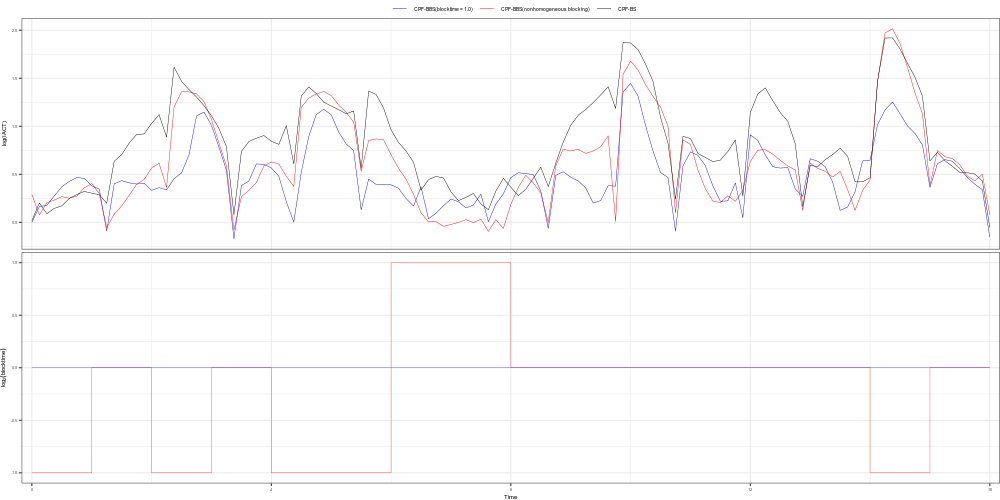

RObject{VecSxp}


In [22]:
R"""
library(latex2exp)
d <- $plot_data
alg_lookup <- c(bbcpf = "CPF-BBS(blocktime = 1.0)", bbcpf_blocked = "CPF-BBS(nonhomogeneous blocking)", 
                cpfbs = "CPF-BS")
variable_lookup <- c(pmux = "L[t]^{(x)}", pmuy = "L[t]^{(y)}", pvx = "V[t]^{(x)}", pvy = "V[t]^{(y)}")
d[["variable_fact"]] <- factor(variable_lookup[d[["variable"]]], levels = unname(variable_lookup))
d[["alg_fact"]] <- factor(alg_lookup[d[["alg"]]], levels = unname(alg_lookup))

alg_colors <- c("blue", "red", "black")
LINESIZE <- 0.2

plt_bbcpf_vs_cpfbs_bigdt <- 
    ggplot(d, aes(x = t, y = log(iact) )) +
    geom_line(aes(color = alg_fact), size = LINESIZE) +
    scale_color_discrete(name = "Algorithm", type = alg_colors) +
    scale_x_continuous(expand = rep(0.01, 2)) +
    labs(y = "log(IACT)", x = "Time") +
    theme_bw() +
    THEME_SIZES +
    theme(legend.position = "top",
          legend.title = element_blank(),
          legend.margin = margin(0, 0, 0, 0),
          legend.box.margin = margin(0, 0, -10, 0),
          strip.text.x = element_text(margin = margin(2, 0, 2, 0, "pt")),
          plot.margin = margin(0, 2, 0, 0),
          panel.spacing = unit(1, "pt")) + 
    theme(axis.text.x = element_blank(),
          axis.title.x = element_blank(),
          axis.ticks.x = element_blank(),
          legend.title = element_blank(),#text(size = 5),
          plot.margin = margin(0, 0, 0, 0)) #+ THEME_POSTER_COLOR

plt_blocking <- ggplot($blocking_df, aes(x = block_l_time, y = log2(blocksize))) +
    geom_step(size = LINESIZE, color = alg_colors[2], alpha = 0.7) +
    geom_step(data = data.frame(block_l_time = c(0.0, 16.0), blocksize = c(1.0, 1.0)), color = alg_colors[1],
              size = LINESIZE, alpha = 0.7) +
    scale_x_continuous(expand = rep(0.01, 2)) +
    coord_cartesian(xlim = c(0, 16), ylim = c(-1, 1)) +
    labs(x = "Time", y = TeX("$\\log_2(blocktime)$")) +
    theme_bw() +
    theme(plot.margin = margin(0, 0, 0, 0)) +
    THEME_SIZES

plt_out <- plt_bbcpf_vs_cpfbs_bigdt / plt_blocking & theme(plot.margin = margin(0, 0, 0, 0))
plt_out
"""